Measured α(23) = -0.042401354052773205 ppm/°C
Label α(23) = -0.05 ppm/°C
Measured β = -0.025525648925395217 ppm/°C²
Label β = -0.026 ppm/°C²
𐤃Nominal at 23°C = +5 ppm perhaps
Temperature at α0 = 22.16943631545832
Test current 100uA (Fluke 8508A)
Target °C per hour = 0.05


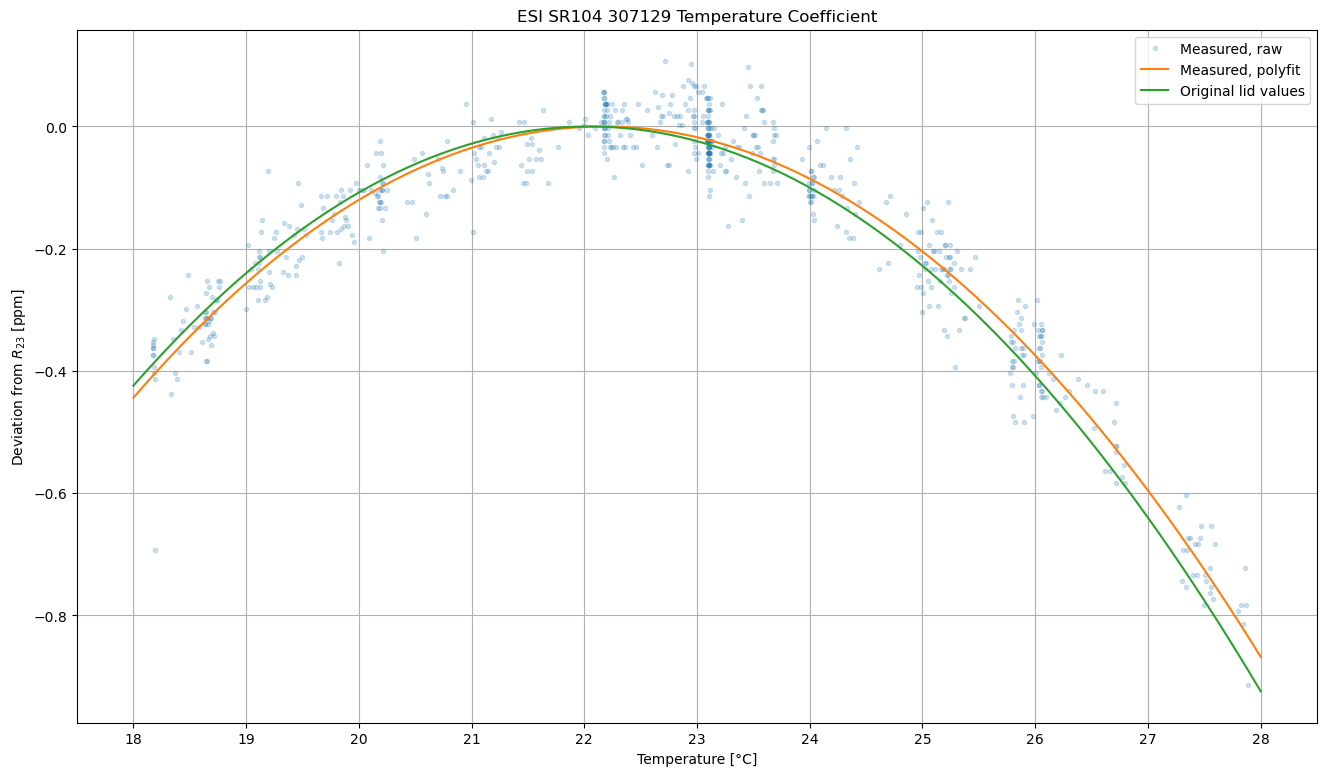

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial import Chebyshev

df=pd.read_csv('https://raw.githubusercontent.com/marcoreps/resistors/refs/heads/main/csv/SR104_TCR_sweep_18_23_all_raw.csv', names=['Time', 'temp_ambient', 'temp_chamber', 'F742A_ambient', 'SR104_DUT', 'SR104_thermistor', 'temp_SR104_well_pt100', 'VHP10k_ambient'], skiprows=1)

# We have one data point per time row, lets merge these into one row every 20m
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
df = df.resample('20min').mean()
df = df.dropna(how='any')

# Drop some rows at the end where temperature control was stopped
df = df[:-80]

# Lets look only at points where ambient temp is good
temp_threshold = 0.1
temp_mask = (df['temp_ambient'] >= (23.00 - temp_threshold)) & \
            (df['temp_ambient'] <= (23.00 + temp_threshold))
filtered_df = df[temp_mask].copy()

# Correcting DMM measurements based on F742A_ambient
f742_best_guess = 1.00001596E+04
filtered_df['dmm_correction_factor']=filtered_df['F742A_ambient']/f742_best_guess
filtered_df['corrected_SR104_DUT']=filtered_df['SR104_DUT']/filtered_df['dmm_correction_factor']
filtered_df['corrected_SR104_thermistor']=filtered_df['SR104_thermistor']/filtered_df['dmm_correction_factor']
filtered_df['corrected_VHP10k_ambient']=filtered_df['VHP10k_ambient']/filtered_df['dmm_correction_factor']

# Computing DUT temperature based on SR104_thermistor
filtered_df['temp_DUT']=23.0+(filtered_df['corrected_SR104_thermistor']-10000.0)/10

# Polyfit
polyfunction = Chebyshev.fit(filtered_df['temp_DUT'], filtered_df['corrected_SR104_DUT'], deg=2)

# Prepare the plot
fig,ax = plt.subplots(figsize=(16,9))
plt.xlabel('Temperature [°C]')
plt.ylabel(r'Deviation from $R_{23}$ [ppm]')
ax.set_xticks(np.arange(18, 28.1, 1))
plt.grid(True, which="both")
plt.title('ESI SR104 307129 Temperature Coefficient')
xpoints = np.linspace(18, 28, 100)
maximum = max(polyfunction(xpoints))

# Optionally indicate underlying data points
plt.plot(filtered_df['temp_DUT'], (filtered_df['corrected_SR104_DUT']-maximum)*100, '.', alpha=0.2, label='Measured, raw')

# Plot our polyfunction between 18 and 28°C
plt.plot(xpoints, (polyfunction(xpoints)-maximum)*100, label='Measured, polyfit')

# Optionally indicate original lid values
lid_maximum = max(-0.05*(xpoints-23)-0.026*(xpoints-23)*(xpoints-23))
plt.plot(xpoints, (-0.05*(xpoints-23)-0.026*(xpoints-23)*(xpoints-23)-lid_maximum), label='Original lid values')

# LFG
plt.legend()

# Optionally print some more stats
derivative=polyfunction.deriv()
print("Measured α(23) = "+str(derivative(23)*100)+" ppm/°C")
print("Label α(23) = -0.05 ppm/°C")
#plt.plot(xpoints, xpoints*derivative(23)-0.274)
print("Measured β = "+str(((((polyfunction(28)+polyfunction(18))/2)-polyfunction(23))/25)*100)+" ppm/°C²")
print("Label β = -0.026 ppm/°C²")
print("𐤃Nominal at 23°C = +5 ppm perhaps")
print("Temperature at α0 = "+str(np.real(polyfunction.deriv().roots()[0])))
print("Test current 100uA (Fluke 8508A)")
print("Target °C per hour = 0.05")

